# Section Goals

- Understand a variety of object detection methods
- We will slowly build up to more complex methods as we go along.

# Section Summary

- Template Matching
> Simply looking for an exact copy of an image in another image
    
- Corner Detection
> Looking for corners in images

- Edge Detection
> Expanding to find general edges of objects

- Grid Detection
> Combining both concepts to find grids in images (useful for appications)

- Contour Detection
> - Allows us to detect foreground vs background images.
> - Also allows for detection of external vs internal contours (e.g. grabbing the eyes and smile from a cartoon smile face).

- Feature Matching 
> More advanced methods of detedting matching objects in another image, even if the target image is not shown exactly the same in the image we are searching.

- Watershed Algorithm
> - Advanced algorithm that allows us to segment images into foreground and background.
> - Also allows us to manually set seeds to choose segments of an image.

- Facial and Eye Detection
> - We'll use Haar Cascades to detect faces in images.
> - Note, this is not yet facial **recognition**, that requires deep learning which we learn in future section.

- At the end, We'll build a full computer vision application that can blur licence plates automatically.
*****

# 1. Template Matching

- Template matching is the simplest form of object detection
- It simply scans a larger image for a provided template by sliding the template target image across the larger image.
- The main option that can be adjusted is the comparison method used as the target template is slid across the larger image.
- The methods are all some sort of correlation based metrics.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

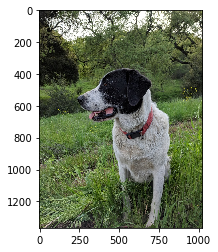

In [2]:
full = cv2.imread('data/sammy.jpg')
full = cv2.cvtColor(full, cv2.COLOR_BGR2RGB)
plt.imshow(full)

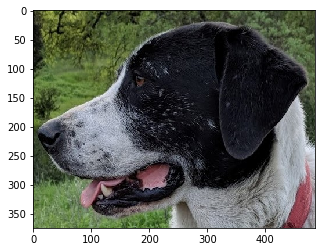

In [3]:
face = cv2.imread('data/sammy_face.jpg')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
plt.imshow(face)

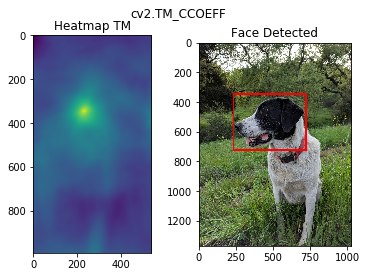

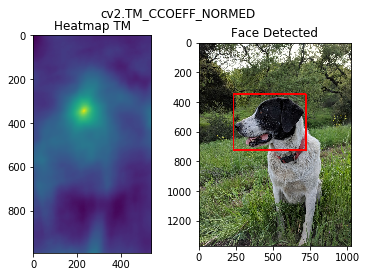

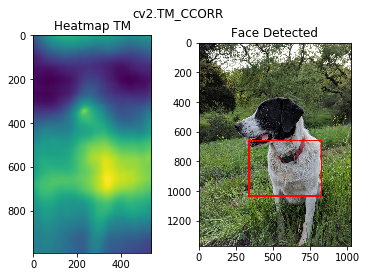

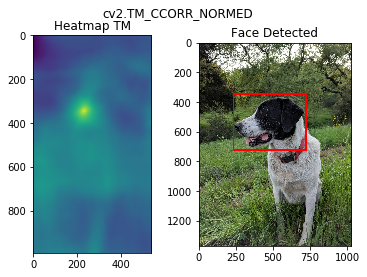

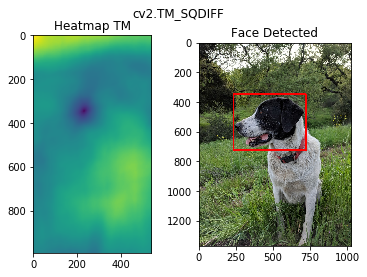

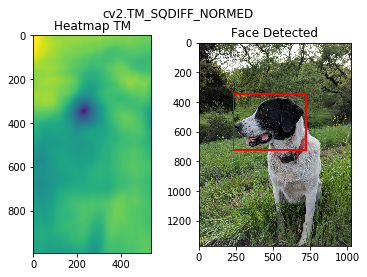

In [4]:
# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 
           'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for m in methods:
    
    full_copy = full.copy()
    method = eval(m)
    # matchTemplate Compares a template against overlapped image regions.
    res = cv2.matchTemplate(full_copy, face, method)
    # minMaxLoc finds the minimum and maximum element values and their positions.
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        
    height, width, channels = face.shape
    bottom_right = (top_left[0] + width, top_left[1] + height)
    
    cv2.rectangle(full_copy, top_left, bottom_right, (255, 0, 0), 10)
    plt.subplot(121)
    plt.imshow(res)
    plt.title('Heatmap TM')
    
    plt.subplot(122)
    plt.imshow(full_copy)
    plt.title('Face Detected')
    
    plt.suptitle(m)
    plt.show()

# Corner Detection

- When thincking about corner detection in computer vision, we should ask oueselves: What is a corner? A corner is a point whose local neighborhood stands in two dominant and different edge directions. A corner can be interpreted as the junction of two edges, where an edge is a sudden change in image brightness. There are various corner detection algorithms. We will ake a look at some of the most popular algorithms:
> - Harris Corner Detection
> - Shi-Tomasi Corner Detection

- Harris Corner Detection
> - The basics intuition is that corners can be detectd by looking for significant change in all directions.

- Shi-Tomasi Corner Detection
> - It made a small modification to the Harris Corner Detector which ended up with better results.
> - It changes the scoring function selection criteria that Harris uses for corner detection.

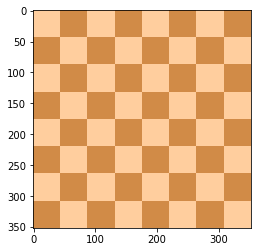

In [5]:
flat_chess = cv2.imread('data/flat_chessboard.png')
flat_chess = cv2.cvtColor(flat_chess, cv2.COLOR_BGR2RGB)
gray_flat_chess = cv2.imread('data/flat_chessboard.png', 0)

plt.imshow(flat_chess)

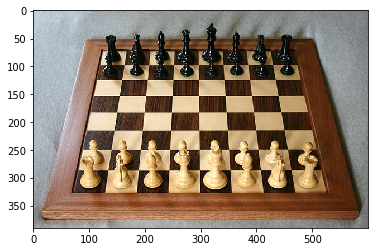

In [6]:
real_chess = cv2.imread('data/real_chessboard.jpg')
real_chess = cv2.cvtColor(real_chess, cv2.COLOR_BGR2RGB)
gray_real_chess = cv2.imread('data/real_chessboard.jpg', 0)

plt.imshow(real_chess)

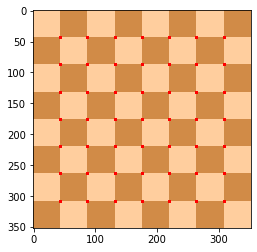

In [7]:
gray = np.float32(gray_flat_chess)

# cornerHarris runs the Harris corner detector on the image.
dst = cv2.cornerHarris(src=gray, blockSize=2, ksize=3, k=0.04)

# dilates the source image using the specified structuring element that determines 
# the shape of a pixel neighborhood over which the maximum is taken
dst = cv2.dilate(dst, None)

flat_chess[dst > 0.01 * dst.max()] = [255, 0, 0]

plt.imshow(flat_chess)

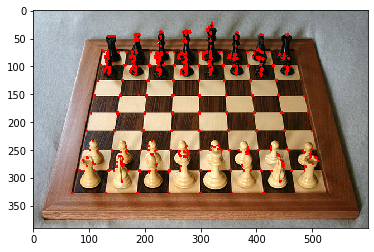

In [8]:
gray = np.float32(gray_real_chess)

# cornerHarris runs the Harris corner detector on the image.
dst = cv2.cornerHarris(src=gray, blockSize=2, ksize=3, k=0.04)

# dilates the source image using the specified structuring element that determines 
# the shape of a pixel neighborhood over which the maximum is taken
dst = cv2.dilate(dst, None)

real_chess[dst > 0.01 * dst.max()] = [255, 0, 0]

plt.imshow(real_chess)

In [9]:
flat_chess = cv2.imread('data/flat_chessboard.png')
flat_chess = cv2.cvtColor(flat_chess, cv2.COLOR_BGR2RGB)

gray_flat_chess = cv2.imread('data/flat_chessboard.png', 0)

real_chess = cv2.imread('data/real_chessboard.jpg')
real_chess = cv2.cvtColor(real_chess, cv2.COLOR_BGR2RGB)

gray_real_chess = cv2.imread('data/real_chessboard.jpg', 0)

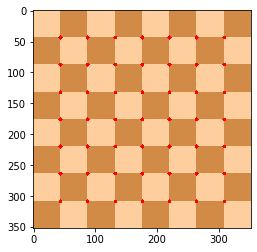

In [10]:
# goodFeaturesToTrack finds the most prominent corners in the image or 
# in the specified image region
corners = cv2.goodFeaturesToTrack(gray_flat_chess, 64, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(flat_chess, (x, y), 3, (255, 0, 0), -1)
    
plt.imshow(flat_chess)

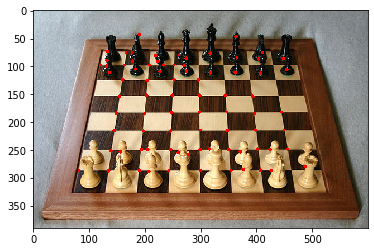

In [11]:
corners = cv2.goodFeaturesToTrack(gray_real_chess, 80, 0.01, 10)
corners = np.int0(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(real_chess, (x, y), 3, (255, 0, 0), -1)
    
plt.imshow(real_chess)

# Edge Detection

- In this part we will learn how to use the Canny edge detector, one of the most popular edge detection algorithms.
- Canny Edge Detection Process
> 1. Apply Gaussian filter to smooth the image in order to remove the noise
> 1. Find the intensity gradients of the image
> 1. Apply non-maximum suppression to get rid of spurious response to edge detection
> 1. Apply double threshold to determine potential edges
> 1. Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.

- For high resolution images where you only want general edges, it is usually a good idea to apply a custom blur before applying the Canny Algorithm. The Canny Algorithm also requires a user to decide on low and high threshold values. We are going to provide an equation for picking a good starting point for threshold values, but often you will need to adjust to your particular image.

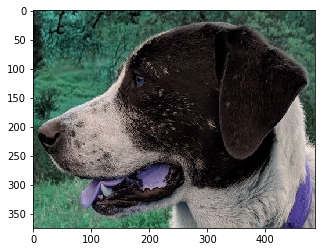

In [12]:
img = cv2.imread('data/sammy_face.jpg')
plt.imshow(img)

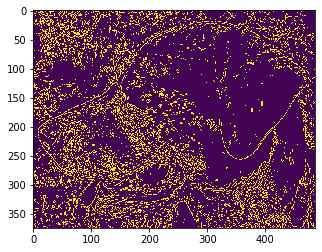

In [13]:
# Finds edges in an image using the Canny algorithm
edges = cv2.Canny(image=img, threshold1=127, threshold2=127)
plt.imshow(edges)

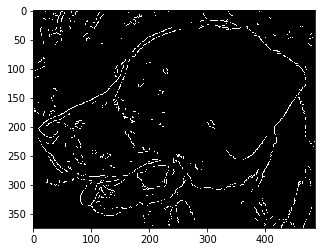

In [14]:
# Compute the median of pixels in the image
med_val = np.median(img)

# LOWER THRESHOLD TO EITHER 0 OR 70% OF THE MEDIAN VALUE WHICHEVER IS GREATER
lower = int(max(0, 0.7 * med_val))

# UPPER THRESHOLD TO EITHER 130% OF THE MEDIAN OR THE MAX 255, WHICH IS SMALLER
upper = int(min(255, 1.3 * med_val))

# Blurs an image using the normalized box filter.
blurred_img = cv2.blur(img, ksize=(7, 7))

edges = cv2.Canny(image=blurred_img, threshold1=upper, threshold2=lower + 50)
plt.imshow(edges, cmap='gray')

# Grid Detection

- Often Cameras can create a distortion in an image, such as radial distortion and tangential distortion.
- A good way to account for these distortions when performing operations like object tracking is to have a recognizable pattern attached to the object being tracked.
- Grid patterns are often use to calibrate cameras and track motion.

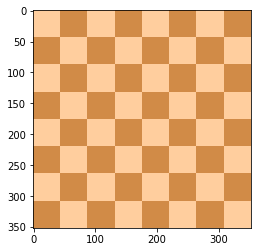

In [15]:
flat_chess = cv2.imread('data/flat_chessboard.png')
flat_chess = cv2.cvtColor(flat_chess, cv2.COLOR_BGR2RGB)

plt.imshow(flat_chess)

In [16]:
# findChessboardCorners Finds the positions of internal corners of the chessboard.
found, corners = cv2.findChessboardCorners(flat_chess, (7, 7))

print(found)

True


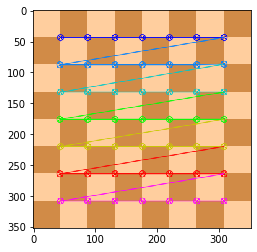

In [17]:
# drawChessboardCorners Renders the detected chessboard corners.
result = cv2.drawChessboardCorners(flat_chess, (7, 7), corners, found)

plt.imshow(result)

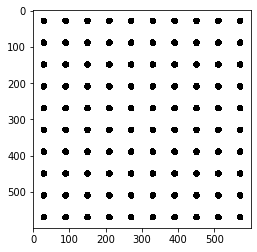

In [18]:
dots = cv2.imread('data/dot_grid.png')
plt.imshow(dots)

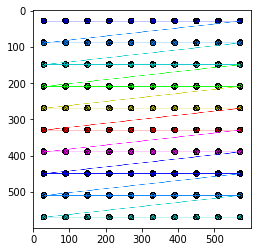

In [19]:
# findCirclesGrid Finds centers in the grid of circles.
found, corners = cv2.findCirclesGrid(dots, (10, 10), cv2.CALIB_CB_SYMMETRIC_GRID)

# drawChessboardCorners Renders the detected chessboard corners.
cv2.drawChessboardCorners(dots, (10, 10), corners, found)
plt.imshow(dots)

# Contour Detection

- Contours are defined as simply a curve joining all the continuous points (along the boundary), having same color or intensity.
- Contours are useful tool for shape analysis and object detection and recognition.
- OpenCV has a built in Contour finder function that can also helps us differentiate between internal and extrnal contours.

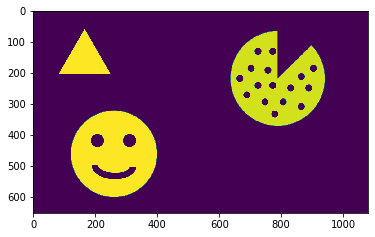

In [20]:
img = cv2.imread('data/internal_external.png', 0)
plt.imshow(img)

In [21]:
# findContours Finds contours in a binary image. The function retrieves contours
# from the binary image using the algorithm Suzuki85. The contours are a 
# useful tool for shape analysis and object detection and recognition.
_, contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

print(type(contours))
print(len(contours))

<class 'list'>
22


In [22]:
len(cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE))

3

In [23]:
external_contours = np.zeros(img.shape)

In [24]:
for i in range(len(contours)):
    
    # External contour
    if hierarchy[0][i][3] == -1:
        # Draws contours outlines or filled contours.
        cv2.drawContours(external_contours, contours, i, 255, -1)

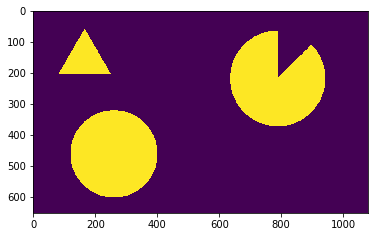

In [25]:
plt.imshow(external_contours)

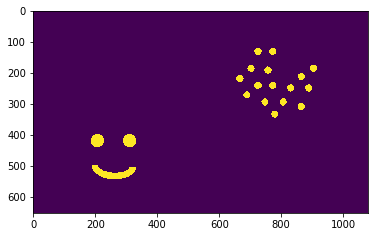

In [26]:
internal_contours = np.zeros(img.shape)

for i in range(len(contours)):
    
    # External contour
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(internal_contours, contours, i, 255, -1)
        
plt.imshow(internal_contours)

# Feature Matching

- Feature matching extracts defining key features from an input image (using ideas from corner, edge, and contour detection).
- The using a distance calculation, finds all the matches in a secondary image.
- This means we are no longer required to have an exact copy of the target image!

We will check out 3 methods:
1. Brute-Force Matching with ORB Descriptors.
1. Brute-Force Matching with SIFT Descriptors and Ratio Test
1. FLANN based Matcher

We will be testing a generic cereal image and seeing if we can find its matching box in the cereal aisle.

In [40]:
def display_img(img, cmap='gray'):
    """
    Plot img in (12, 10) size with gray or a giving cmap
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

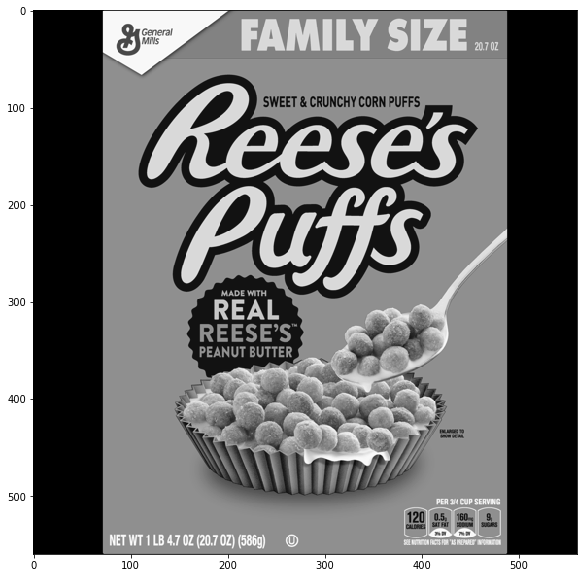

In [28]:
reeses = cv2.imread('data/reeses_puffs.png', 0)
display_img(reeses)

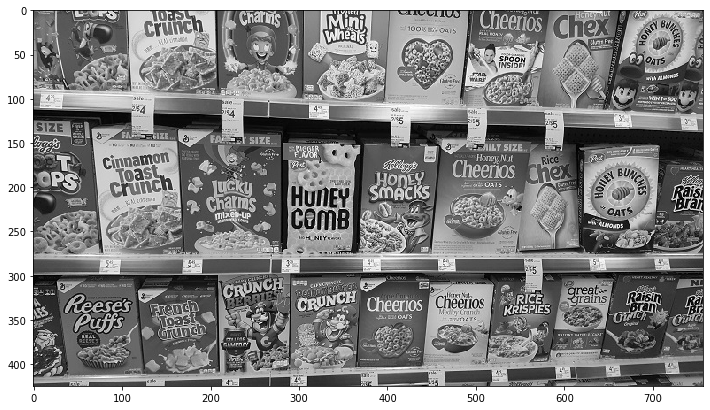

In [29]:
cereals = cv2.imread('data/many_cereals.jpg', 0)
display_img(cereals)

## Oriented FAST and Rotated BRIEF (ORB)

In [31]:
# The ORB constructor
orb = cv2.ORB_create()

# Detects keypoints and computes the descriptors
kp1, des1 = orb.detectAndCompute(reeses, None)
kp2, des2 = orb.detectAndCompute(cereals, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Finds the best match for each descriptor from a query set.
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x:x.distance)

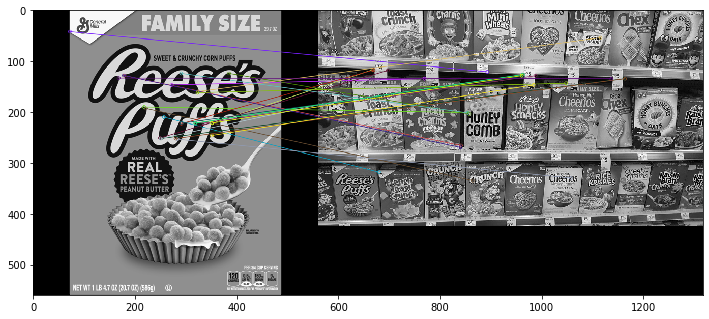

In [32]:
# Draws the found matches of keypoints from two images.
reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25], 
                                 None, flags=2)
display_img(reeses_matches)

## Scale Invariante Feature Transform (SIFT)

In [33]:
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)

bf = cv2.BFMatcher()

# knnMatch Finds the k best matches for each descriptor from a query set.
matches = bf.knnMatch(des1, des2, k=2)

In [34]:
good = []

for match1, match2 in matches:
    if match1.distance < 0.75 * match2.distance:
        good.append([match1])
        
reeses_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags=2)

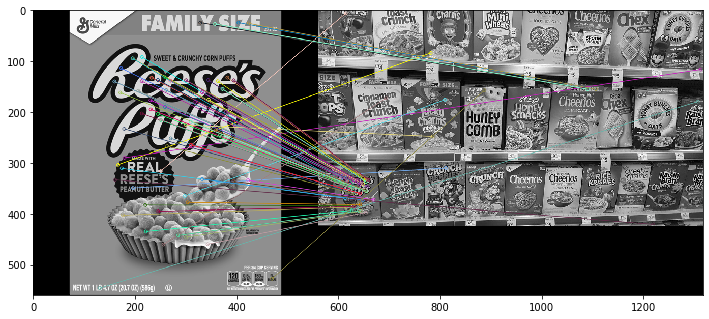

In [35]:
display_img(reeses_matches)

In [36]:
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)

In [37]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

In [38]:
good = []

for match1, match2 in matches:
    if match1.distance < 0.75 * match2.distance:
        good.append([match1])
        
reeses_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags=2)

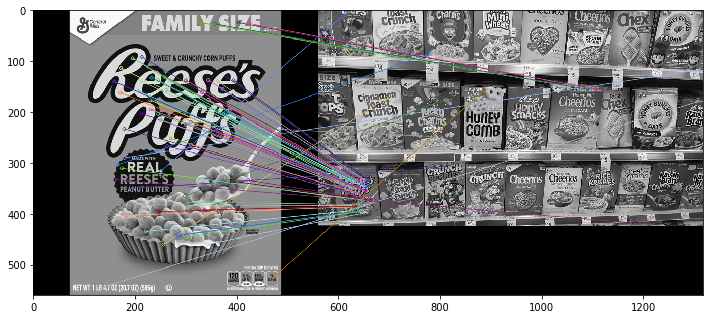

In [39]:
display_img(reeses_matches)

In [41]:
matchesMask = [[0, 0] for i in range(len(matches))]

for i, (match1, match2) in enumerate(matches):
    if match1.distance < 0.7 * match2.distance:
        matchesMask[i] = [1, 0]
        
draw_params = dict(matchColor=(0, 255, 0), 
                   singlePointColor=(255, 0, 0), 
                   matchesMask=matchesMask, 
                   flags=0)

reeses_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, matches, None, **draw_params)

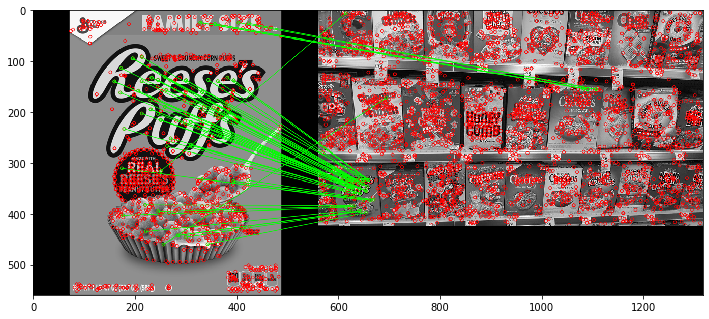

In [42]:
display_img(reeses_matches)

# Watershed Algorithm

- In geography, a watershed is a land area that channels rainfull and snowmelt to creeks, streams, and rivers, and eventually to outflow points such as reservoirs, bays, and the ocean. These watersheds can then be segmented as topographical maps with boundaries. Metaphorically, the watershed algorithm transformation treats the image it operates upon like a topographic map, with the brightness of each point representing its height, and finds the lines that run along the tops of ridges. Any grayscale image can be viewed as a topographic surface where high intensity denotes peaks and hills while low intensity denotes valleys.

- The algorithm can then fill every isolated valleys (local minima) with different colored water (labels). As the water rises, depending on the peaks (gradients) nearby, water from different valleys (different segment of the image), with different colors could start to merge. To avoid this merging, the algorithm creates barriers (segment edge boundaries) in locations where water merges. This algorithm is especially useful for segmenting images into background and foreground in situations that are difficult for other algorithms. A common example is the use of coins next to teach other on a table.

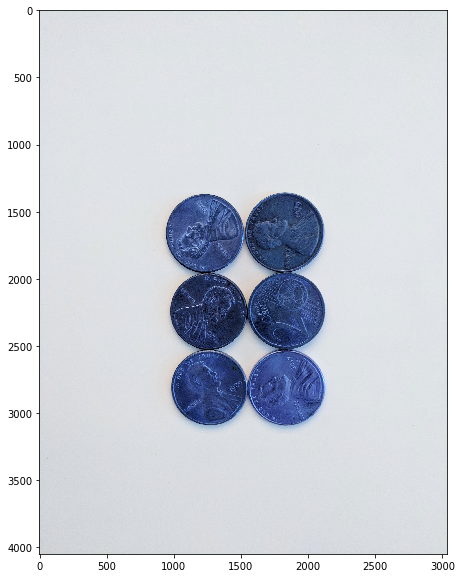

In [43]:
sep_coins = cv2.imread('data/pennies.jpg')
display_img(sep_coins)

In [44]:
# Median Blur, Blurs an image using the median filter.
sep_blur = cv2.medianBlur(sep_coins, 25)

# Grayscale
gray_sep_coins = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)

# Binary Threshold, Applies a fixed-level threshold to each array element.
ret, sep_thresh = cv2.threshold(gray_sep_coins, 160, 255, cv2.THRESH_BINARY_INV)

# Find Contours, Finds contours in a binary image
_, contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

In [45]:
for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

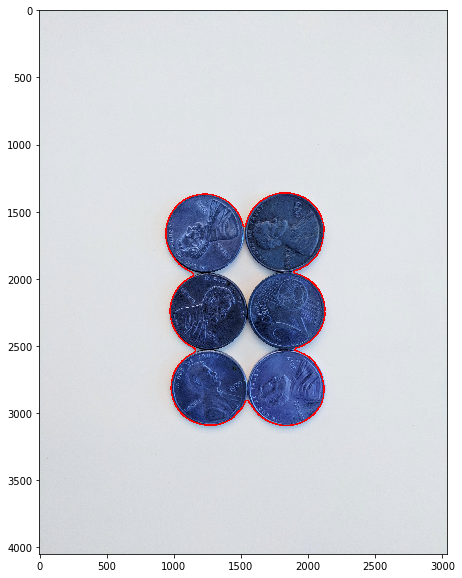

In [46]:
display_img(sep_coins)

In [49]:
img = cv2.imread('data/pennies.jpg')
img = cv2.medianBlur(img, 35)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise Removal
kernel = np.ones((3, 3), np.uint8)

# morphologyEx Performs advanced morphological transformations.
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# The map labels each pixel of the image with the nearest obstacle pixel.
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

ret, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)

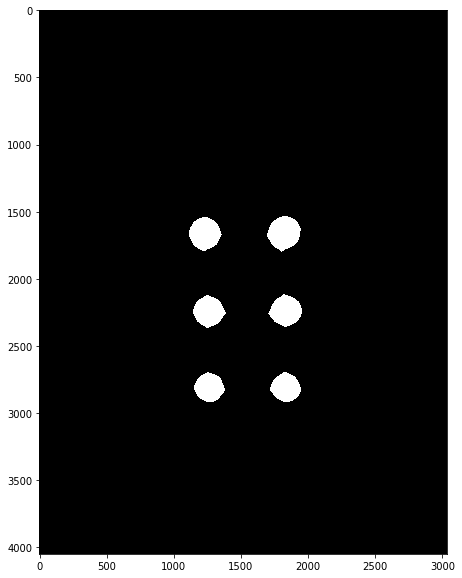

In [50]:
display_img(sure_fg)

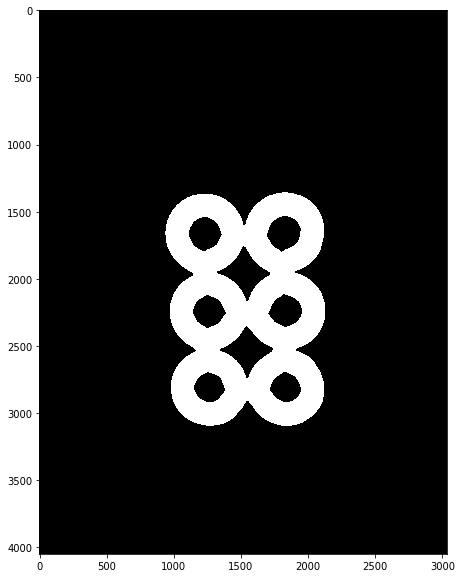

In [51]:
sure_fg = np.uint8(sure_fg)

# Calculates the per-element difference between two arrays or array and a scalar.
unknown = cv2.subtract(sure_bg, sure_fg)

display_img(unknown)

In [52]:
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown==255] = 0

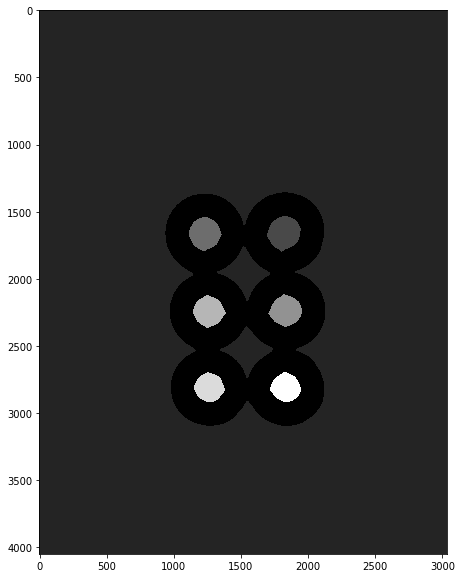

In [53]:
display_img(markers)

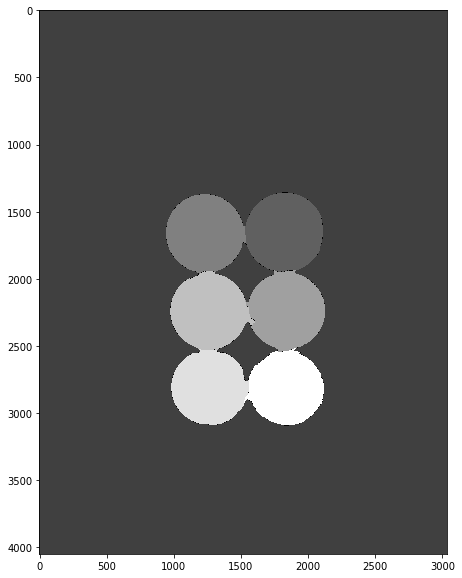

In [54]:
# watershed Performs a marker-based image segmentation using the watershed algorithm.
# The function implements one of the variants of watershed, non-parametric 
# marker-based segmentation algorithm, described in Meyer92
markers = cv2.watershed(img, markers)

display_img(markers)

In [55]:
_, contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10)

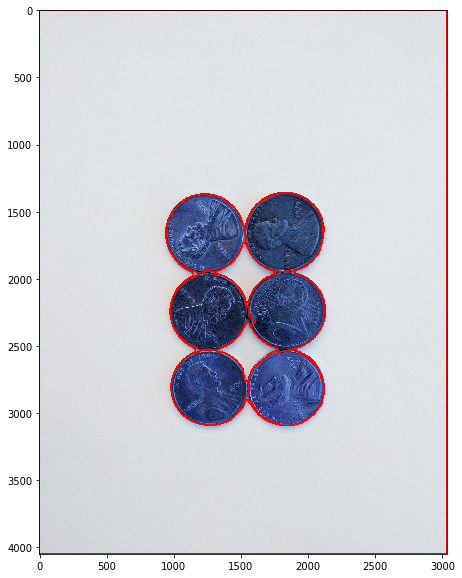

In [56]:
display_img(sep_coins)

# Custom Seeds with Watershed Algorithm

In [57]:
road = cv2.imread('data/road_image.jpg')
road_copy = road.copy()

In [58]:
marker_img = np.zeros(road.shape[:2], dtype=np.int32)

segments = np.zeros(road.shape, dtype=np.uint8)

In [59]:
from matplotlib import cm

def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3]) * 255)
    
colors = []
for i in range(10):
    colors.append(create_rgb(i))

In [60]:
colors

[(31.0, 119.0, 180.0),
 (255.0, 127.0, 14.0),
 (44.0, 160.0, 44.0),
 (214.0, 39.0, 40.0),
 (148.0, 103.0, 189.0),
 (140.0, 86.0, 75.0),
 (227.0, 119.0, 194.0),
 (127.0, 127.0, 127.0),
 (188.0, 189.0, 34.0),
 (23.0, 190.0, 207.0)]

In [61]:
n_markers = 10
current_marker = 1
marks_updated = False

def mouse_callback(event, x, y, flags, param):
    global marks_updated
    
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(marker_img, (x, y), 10, (current_marker), -1)
        cv2.circle(road_copy, (x,y), 10, colors[current_marker], -1)
        marks_updated = True

In [62]:
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image', mouse_callback)

while True:
    cv2.imshow('Watershed Segments', segments)
    cv2.imshow('Road Image', road_copy)
    
    k = cv2.waitKey(1)
    
    if k == 27:
        break
        
    elif k == ord('c'):
        road_copy = road.copy()
        marker_img = np.zeros(road.shape[:2], dtype=np.int32)
        segments = np.zeros(road.shape, dtype=np.uint8)
        
    elif k > 0 and chr(k).isdigit():
        current_marker = int(chr(k))
        
    if marks_updated:
        marker_img_copy = marker_img.copy()
        cv2.watershed(road, marker_img_copy)
        
        segemnts = np.zeros(road.shape, dtype=np.uint8)
        
        for color_ind in range(n_markers):
            segments[marker_img_copy==(color_ind)] = colors[color_ind]
            
            
cv2.destroyAllWindows()

# Introduction to Face Detection

- in this part we will explore face detection using Haar Cascades, which is key component of the Viola-Jones object detection framework. We will be able to very quickly detect if a face is in an image and locate it. However we won't know who's face it belongs to. We would need a really large dataset and deep learning for facial recognition.

- The main feature types are:
> - Edge Features
> - Line Features
> - Four-rectangle Features

- Each feature is a single value obtained by subtracting sum of pixels under white rectangle from sum of pixels under black rectangle. Realistically, our images won't be perfect edges or lines. Calculating these sums for the entire image would be very computationally expensive. The Viola-Jones algorithm solves this by using the integral image. Resulting in an O(1) running time of the algorithm. An integral image is also known as a summed area table. To sum up a subrectangle of its values; each colored spot highlights the sum inside the rectangle of that color. The algorithm also saves time by going through a cascade of classifiers. This means we will treat the image to a series (a cascade) of classifiers based on the simple features shown earlier. Once an image fails a classifier, we can stop attempting to detect a face.

- A common misconception behind face detection with this algorithm is that the algorithm slowly scans the entire image looking for a face. This would be very inefficient, instead we pass the cascade of classifiers.

1. First we need a front facing image of a person's face.
2. Then turn it to grayscale.
3. Then we will begin the search for Haar Cascade Features.
4. One of the very first features searched for is an edge feature indicating eyes and cheeks. If it passed, then we search for the next feature, such as the bridge of the nose. We continue through this cascade (which can be thousands of features). Until the algorithm detects the face.

- The downside to this algorithm is the very large data sets needed to create your own features. However, luckily many pre-trained sets of features already exist.

In [63]:
nadia = cv2.imread("data/Nadia_Murad.jpg", 0)
denis = cv2.imread("data/Denis_Mukwege.jpg", 0)
solvay = cv2.imread("data/solvay_conference.jpg", 0)

In [64]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

In [65]:
def detect_face(img):
    face_img = img.copy()
    face_rects = face_cascade.detectMultiScale(face_img)
    
    for (x, y, w, h) in face_rects:
        cv2.rectangle(face_img, (x,y), (x+w, y+h), (255, 255, 255), 5)
        
    return face_img

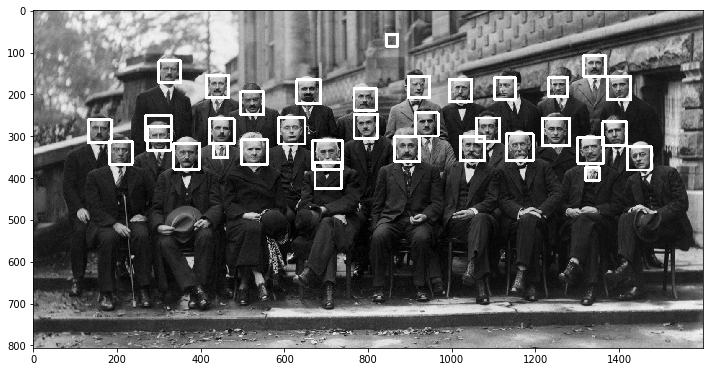

In [66]:
result = detect_face(solvay)
display_img(result)

In [67]:
def adj_detect_face(img):
    face_img = img.copy()
    face_rects = face_cascade.detectMultiScale(face_img, scaleFactor=1.2, minNeighbors=5)
    
    for (x, y, w, h) in face_rects:
        cv2.rectangle(face_img, (x,y), (x+w, y+h), (255, 255, 255), 5)
        
    return face_img

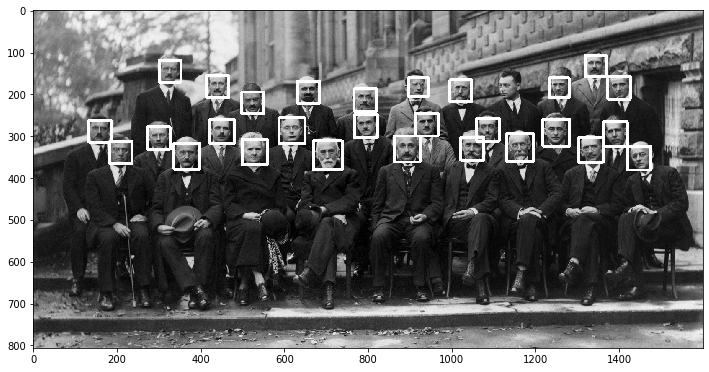

In [68]:
result = adj_detect_face(solvay)
display_img(result)

In [69]:
eye_cascade = cv2.CascadeClassifier('data/haarcascades/haarcascade_eye.xml')

def detect_eyes(img):
    face_img = img.copy()
    eyes_rects = eye_cascade.detectMultiScale(face_img, scaleFactor=1.2, minNeighbors=5)
    
    for (x, y, w, h) in eyes_rects:
        cv2.rectangle(face_img, (x,y), (x+w, y+h), (255, 255, 255), 5)
        
    return face_img

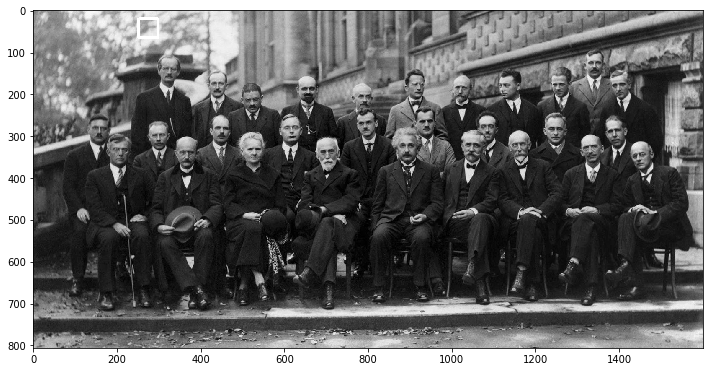

In [70]:
result = detect_eyes(solvay)
display_img(result)

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read(0)
    frame = detect_face(frame)
#     frame = detect_eyes(frame)
    cv2.imshow('Video Face Detect', frame)
    
    k = cv2.waitKey(1)
    if k == 27:
        break
        
cap.release()
cv2.destroyAllWindows()